In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Load cafepy package -----
from cafepy import utils
from cafepy import verif

# My local packages -----
from mygeneralfuncs import *

import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
# from IPython.display import clear_output
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Initialise dask (currently not working on vm31)

In [2]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4)
# client

# Construct xarray objects for forecasts and observations

In [3]:
# Resampling details -----
resample_freq = '1MS' # Must be '1MS' for monthly
resample_method = 'sum'

# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/061_tprat/'

In [4]:
# Initialization dates (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2/2002','6/2005' , freq='1MS')  # Must be '1MS' for monthly

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years
no_leap = 2001
n_incr = len(pd.date_range('1/1/' + str(no_leap),
                           '12/1/' + str(no_leap+FCST_LENGTH-1),
                           freq=resample_freq)) # number of lead_time increments
lead_times = range(1,n_incr+1)

### Construct forecasts xarray object

In [5]:
# import pdb, traceback, sys
filename = 'atmos_daily*'

# ==================================================
# Initialize xarray object for first init_date -----
# ==================================================
with timer():
    print(f'Gathering data for forecast started on {init_dates[0].month}-{init_dates[0].year}...')
    
    ds_fcst = xr.open_mfdataset(fcst_folder + 
                                '/yr' + str(init_dates[0].year) + 
                                '/mn' + str(init_dates[0].month) + 
                                '/OUTPUT.' + str(ensembles[0]) + 
                                '/' + filename, autoclose=True)
    ds_fcst.coords['ensemble'] = ensembles[0]

    for ensemble in ensembles[1:]:
        ds_temp = xr.open_mfdataset(fcst_folder + 
                                    '/yr' + str(init_dates[0].year) + 
                                    '/mn' + str(init_dates[0].month) + 
                                    '/OUTPUT.' + str(ensemble) + 
                                    '/' + filename, autoclose=True)
        # Concatenate along 'ensemble' dimension/coordinate -----
        ds_temp.coords['ensemble'] = ensemble
        ds_fcst = xr.concat([ds_fcst, ds_temp],'ensemble')

    # Resample to desired frequency and resave time as lead time -----
    ds_fcst = ds_fcst.resample(freq=resample_freq, dim='time', how=resample_method) \
                               .isel(time = range(len(lead_times)))
    ds_fcst = ds_fcst.rename({'time' : 'lead_time'})
    ds_fcst['lead_time'] = lead_times

    # Initialize 'init_date' coordinate -----
    ds_fcst.coords['init_date'] = init_dates[0]
    ds_fcst = ds_fcst.expand_dims('init_date')
    
# ==============================================
# Loop over remaining initialization dates -----
# ==============================================
for init_date in init_dates[1:]:
    with timer():
        year = init_date.year
        month = init_date.month
        print(f'Gathering data for forecast started on {month}-{year}...')

        # There is a bug in xarray that causes an 'invalid type promotion' sometimes when concatenating 
        # The following while loop provides a work-around 
        more_ensembles = True
        first_chunk = True
        current_ensemble = 1

        while more_ensembles:
            try:
                # Initialize xarray object for first ensemble -----
                ds_temp1 = xr.open_mfdataset(fcst_folder + 
                                             '/yr' + str(year) + 
                                             '/mn' + str(month) + 
                                             '/OUTPUT.' + str(ensembles[current_ensemble-1]) + 
                                             '/' + filename, autoclose=True)
                ds_temp1.coords['ensemble'] = ensembles[current_ensemble-1]

                for ensemble in ensembles[current_ensemble:]:
                    ds_temp2 = xr.open_mfdataset(fcst_folder + 
                                                '/yr' + str(year) + 
                                                '/mn' + str(month) + 
                                                '/OUTPUT.' + str(ensemble) + 
                                                '/' + filename, autoclose=True)
                    # Concatenate along 'ensemble' dimension/coordinate -----
                    ds_temp2.coords['ensemble'] = ensemble
                    ds_temp1 = xr.concat([ds_temp1, ds_temp2],'ensemble')

                # try:
                if first_chunk:
                    ds_chunk = ds_temp1
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                # except:
                #     type, value, tb = sys.exc_info()
                #     traceback.print_exc()
                #     pdb.post_mortem(tb)

                more_ensembles = False
            except TypeError:
                if first_chunk:
                    ds_chunk = ds_temp1
                    first_chunk = False
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                current_ensemble = ensemble

        # Resample to desired frequency and resave time as lead time -----
        ds_chunk = ds_chunk.resample(freq=resample_freq, dim='time', how=resample_method) \
                           .isel(time = range(len(lead_times)))
        ds_chunk = ds_chunk.rename({'time' : 'lead_time'})
        ds_chunk['lead_time'] = lead_times

        # Concaneate along 'init_date' dimension/coordinate -----
        ds_chunk.coords['init_date'] = init_date
        ds_fcst = xr.concat([ds_fcst, ds_chunk],'init_date')

Gathering data for forecast started on 2-2002...
   Elapsed: 5.664447069168091 sec
Gathering data for forecast started on 3-2002...
   Elapsed: 5.613842248916626 sec
Gathering data for forecast started on 4-2002...
   Elapsed: 5.954415559768677 sec
Gathering data for forecast started on 5-2002...
   Elapsed: 5.693514585494995 sec
Gathering data for forecast started on 6-2002...
   Elapsed: 6.042593717575073 sec
Gathering data for forecast started on 7-2002...
   Elapsed: 17.696101188659668 sec
Gathering data for forecast started on 8-2002...
   Elapsed: 5.487928628921509 sec
Gathering data for forecast started on 9-2002...
   Elapsed: 6.96064567565918 sec
Gathering data for forecast started on 10-2002...
   Elapsed: 7.258666753768921 sec
Gathering data for forecast started on 11-2002...
   Elapsed: 5.55948281288147 sec
Gathering data for forecast started on 12-2002...
   Elapsed: 7.59669828414917 sec
Gathering data for forecast started on 1-2003...
   Elapsed: 12.615964412689209 sec
Ga

#### Rechunk

In [6]:
# Rechunk for chunksizes of at least 1,000,000 elements -----
ds_fcst = ds_fcst.chunk(chunks={'ensemble' : len(ensembles), 'lead_time' : len(lead_times)})

# Overwrite init_dates in case didn't fully load -----
init_dates = ds_fcst.init_date.values

### Construct observations xarray object

In [7]:
filename = 'fcst_phy2m125.061_tprat.'

fcst_years = [pd.to_datetime(init_dates).year]
fcst_year_min = min(fcst_years)[0]
fcst_year_max = max(fcst_years)[-1] + FCST_LENGTH

# ===================================================
# Only load years for which forecast data exist -----
# ===================================================
with timer():
    print(f'Gathering data for observations...')
    
    ds_temp1 = xr.open_mfdataset(obsv_folder + filename + str(fcst_year_min) + '*')
    for year_to_load in range(fcst_year_min+1,fcst_year_max+1):
        ds_temp2 = xr.open_mfdataset(obsv_folder + filename + str(year_to_load) + '*')
        ds_temp1 = xr.concat([ds_temp1, ds_temp2],'initial_time0_hours')

    # Standardize naming -----
    ds_temp1 = ds_temp1.rename({'initial_time0_hours':'time',
                                      'g0_lon_3':'lon',
                                      'g0_lat_2':'lat',
                                      'TPRAT_GDS0_SFC_ave3h':'precip'})

    # Resample to desired frequency -----
    ds_temp1 = ds_temp1.resample(freq=resample_freq, dim='time', how=resample_method)
    
    # ===============================================
    # Stack to resemble ds_forecast coordinates -----
    # ===============================================
    # Initialize xarray object for first lead_time -----
    start_index = np.where(ds_temp1.time == np.datetime64(init_dates[0]))[0].item()
    ds_obsv = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))
    ds_obsv.coords['init_date'] = init_dates[0]
    ds_obsv = ds_obsv.expand_dims('init_date')
    ds_obsv = ds_obsv.rename({'time' : 'lead_time'})
    ds_obsv['lead_time'] = lead_times
    
    # Loop over remaining lead_time -----
    for init_date in init_dates[1:]:
        start_index = np.where(ds_temp1.time == np.datetime64(init_date))[0].item()
        ds_temp3 = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))

        # Concatenate along 'lead_time' dimension/coordinate -----
        ds_temp3 = ds_temp3.rename({'time' : 'lead_time'})
        ds_temp3['lead_time'] = lead_times
        ds_temp3.coords['init_date'] = init_date
        ds_obsv = xr.concat([ds_obsv, ds_temp3],'init_date') 

Gathering data for observations...
   Elapsed: 1.2379179000854492 sec


#### Rechunk

In [8]:
# Rechunk for chunksizes of at least 1,000,000 elements -----
ds_obsv = ds_obsv.chunk(chunks={'init_date' : len(init_dates)})

# Methods for probabilistic forecasts

## Rank histogram

#### E.g., for precipitation averaged over region around Tasmania

In [9]:
with timer():
    variable = 'precip'

    # Region of interest -----
    region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

    # Including unit conversion to mm/month
    da_fcst = cafeutils.calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region).compute() 

    # The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
    da_obsv = cafeutils.calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region).compute()

   Elapsed: 82.7417540550232 sec


#### Rank the data and compute histograms as a function of lead time

In [10]:
rank_histogram = cafeverif.compute_rank_histogram(da_fcst, da_obsv, indep_dims='init_date')

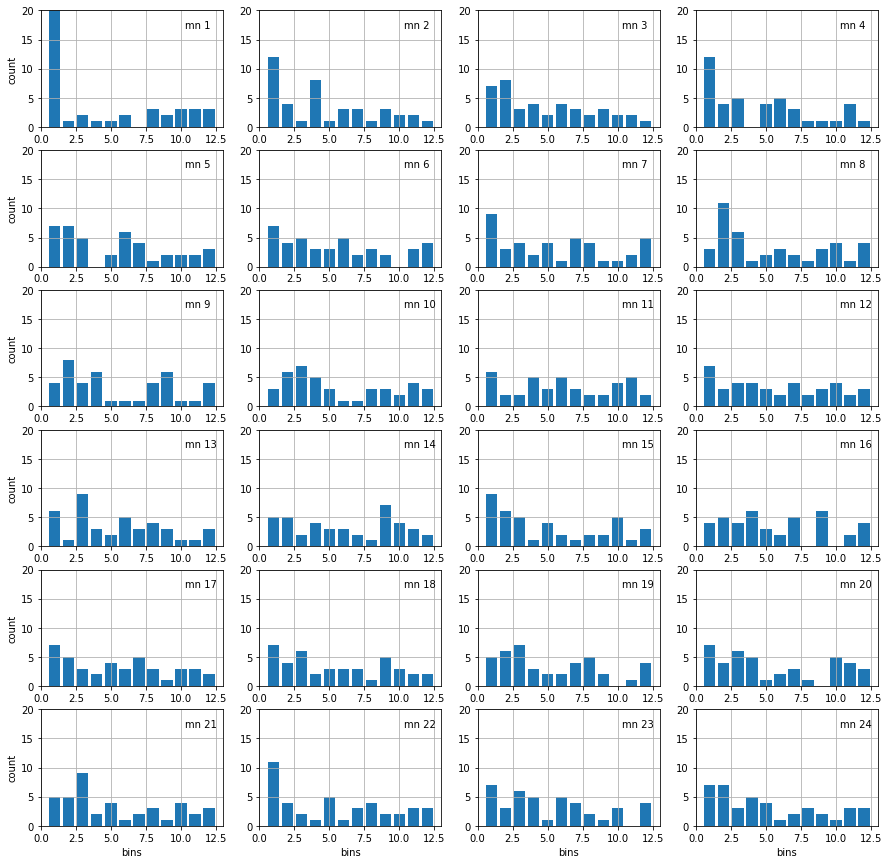

In [11]:
ncol = 4; nrow = int(ceil(len(lead_times)/ncol));
fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

for idx,ax in enumerate(axs.reshape(-1)): 
    ax.grid()
    ax.bar(rank_histogram.bins,rank_histogram.isel(lead_time=idx, drop=True))
    ax.set_ylim(0,rank_histogram.max())
    ax.text(10.3,0.85*rank_histogram.max(),'mn '+str(idx+1))
    
    if idx % ncol == 0:
        ax.set_ylabel('count')
        
    if idx / ncol >= nrow - 1:
        ax.set_xlabel('bins')

#### Rank the data and compute histograms for all lead times

In [12]:
rank_histogram = cafeverif.compute_rank_histogram(da_fcst, da_obsv, indep_dims=('init_date','lead_time'))

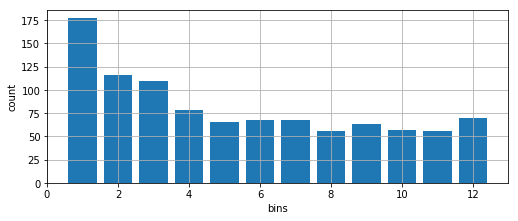

In [13]:
fig1 = plt.figure(figsize=(8,3))

ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.grid()
ax1.bar(rank_histogram.bins,rank_histogram)
ax1.set_xlabel('bins')
ax1.set_ylabel('count');

## (Continuous) ranked probability score

#### E.g., for precipitation averaged over region around Tasmania

In [14]:
variable = 'precip'

# Region of interest -----
region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

# Including unit conversion to mm/month
# da_fcst = cafeutils.calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region).compute() 

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
# da_obsv = cafeutils.calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region).compute()

#### Compute rps as a function of lead time

In [15]:
# Specify bins for computation of cdf -----
bins = linspace(0,200,20)

# Compute ranked probability score -----
rps = cafeverif.compute_rps(da_fcst, da_obsv, bins=bins, indep_dims='init_date', ensemble_dim='ensemble')

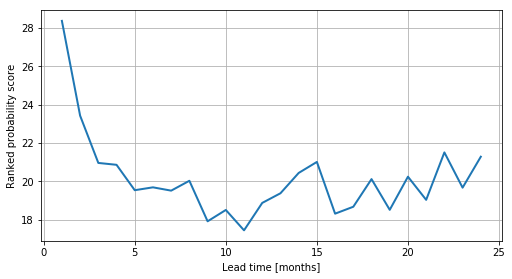

In [16]:
fig1 = plt.figure(figsize=(8,4))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(rps['lead_time'],rps,linewidth=2)
ax.set_xlabel('Lead time [months]')
ax.set_ylabel('Ranked probability score');

## Reliability diagram

#### E.g. for the event of monthly rainfall over Tasmania being greater than 60 mm/month but less than 200 mm/month

In [17]:
variable = 'precip'

event = '((> 60) and (< 200)) or (> 1000) or (= 500.0)' # for example

# Region of interest -----
# region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

# da_fcst = cafeutils.calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region).compute() 

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
# da_obsv = cafeutils.calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region).compute()

#### Compute reliability as a function of lead time 

In [18]:
# Compute the event data for forecast likelihood and observations -----
fcst_likelihood = cafeverif.compute_likelihood(cafeverif.did_event(da_fcst, event))
obsv_logical = cafeverif.did_event(da_obsv, event)

# Compute the reliability -----
fcst_probabilities = linspace(0,1,len(da_fcst['ensemble'])+1)
reliability = cafeverif.compute_reliability(fcst_likelihood,obsv_logical,
                                            fcst_probabilities,indep_dims='init_date')

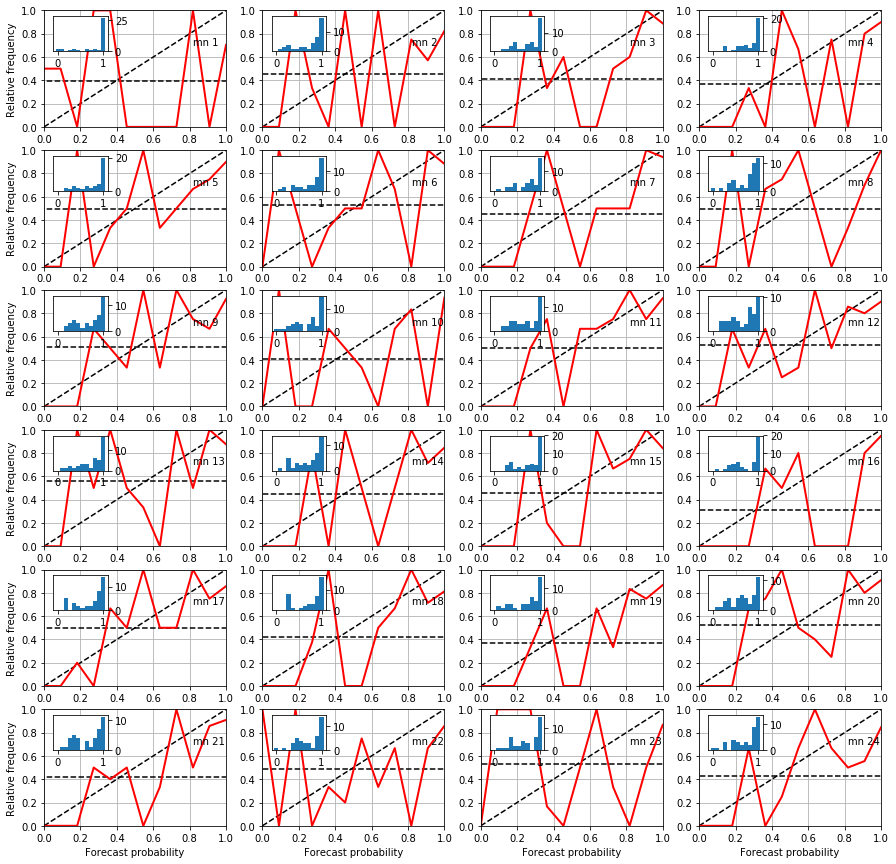

In [19]:
ncol = 4; nrow = int(ceil(len(lead_times)/ncol));
fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

for idx,ax in enumerate(axs.reshape(-1)): 
    ax.grid()
    ax.plot([0, 1],[0, 1],'k--')
    sample_clim = reliability['relative_freq'].isel(lead_time=idx, drop=True).mean()
    ax.plot([-1, 2],[sample_clim, sample_clim],'k--')
    ax.plot(reliability['forecast_probability'],
            reliability['relative_freq'].isel(lead_time=idx, drop=True),'r',linewidth=2)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0.82,0.7,'mn '+str(idx+1))
    
    if idx % ncol == 0:
        ax.set_ylabel('Relative frequency')
        
    if idx / ncol >= nrow - 1:
        ax.set_xlabel('Forecast probability')
    
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    subpos = [0.05,0.65,0.3,0.3]
    inax_position  = ax.transAxes.transform(subpos[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= subpos[2]
    height *= subpos[3] 
    subax = fig.add_axes([x,y,width,height])
    subax.yaxis.tick_right()
    subax.bar(reliability['forecast_probability'],reliability['fcst_number'].isel(lead_time=idx, drop=True),
              width=reliability['forecast_probability'][1])

#### Compute reliability across all lead times

In [20]:
# Compute the event data for forecast likelihood and observations -----
fcst_likelihood = cafeverif.compute_likelihood(cafeverif.did_event(da_fcst, event))
obsv_logical = cafeverif.did_event(da_obsv, event)

# Compute the reliability -----
fcst_probabilities = linspace(0,1,len(da_fcst['ensemble'])+1)
reliability = cafeverif.compute_reliability(fcst_likelihood,obsv_logical,fcst_probabilities,indep_dims=['init_date','lead_time'])

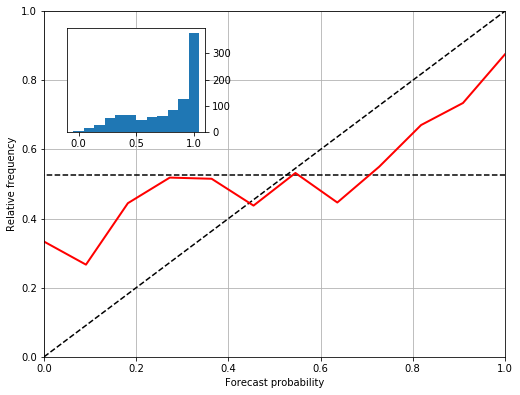

In [21]:
fig1 = plt.figure(figsize=(8,6))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot([0, 1],[0, 1],'k--')
sample_clim = reliability['relative_freq'].mean()
ax.plot([-1, 2],[sample_clim, sample_clim],'k--')
ax.plot(reliability['forecast_probability'],reliability['relative_freq'],'r',linewidth=2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('Forecast probability')
ax.set_ylabel('Relative frequency');

fig = plt.gcf()
box = ax.get_position()
width = box.width
height = box.height
subpos = [0.05,0.65,0.3,0.3]
inax_position  = ax.transAxes.transform(subpos[0:2])
transFigure = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
x = infig_position[0]
y = infig_position[1]
width *= subpos[2]
height *= subpos[3] 
subax = fig.add_axes([x,y,width,height])
subax.yaxis.tick_right()
subax.bar(reliability['forecast_probability'],reliability['fcst_number'],
          width=reliability['forecast_probability'][1]);

## Brier score

#### E.g. for the event of monthly rainfall over Tasmania being greater than 100 mm/month

In [22]:
variable = 'precip'

event = '> 100' # for example

# Region of interest -----
# region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

# da_fcst = cafeutils.calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region).compute() 

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
# da_obsv = cafeutils.calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region).compute()

#### Compute Brier scores as a function of lead time

In [23]:
# Compute the event data for forecast likelihood and observations -----
fcst_likelihood = cafeverif.compute_likelihood(cafeverif.did_event(da_fcst, event))
obsv_logical = cafeverif.did_event(da_obsv, event)

# Compute the Brier score -----
fcst_probabilities = linspace(0,1,len(da_fcst['ensemble'])-6)
Brier = cafeverif.compute_Brier_score(fcst_likelihood,obsv_logical,fcst_prob=fcst_probabilities,indep_dims='init_date')

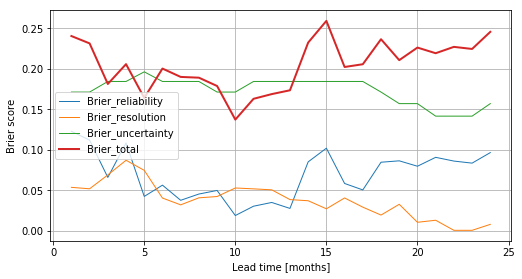

In [24]:
fig1 = plt.figure(figsize=(8,4))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(Brier['lead_time'],Brier['Brier_reliability'],linewidth=1)
ax.plot(Brier['lead_time'],Brier['Brier_resolution'],linewidth=1)
ax.plot(Brier['lead_time'],Brier['Brier_uncertainty'],linewidth=1)
ax.plot(Brier['lead_time'],Brier['Brier_total'],linewidth=2)
ax.set_xlabel('Lead time [months]')
ax.set_ylabel('Brier score')
ax.legend();

## Relative operating characteristic

#### E.g. for the event of monthly rainfall over Tasmania being greater than 100 mm/month

In [25]:
variable = 'precip'

event = '> 100' # for example

# Region of interest -----
# region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

# da_fcst = calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region).compute() 

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
# da_obsv = calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region).compute()

#### Compute ROC diagrams as a function of lead time

In [26]:
# Compute the event data for forecast likelihood and observations -----
fcst_likelihood = cafeverif.compute_likelihood(cafeverif.did_event(da_fcst, event))
obsv_logical = cafeverif.did_event(da_obsv, event)

# Compute the roc -----
fcst_probabilities = linspace(0,1,len(da_fcst['ensemble'])+1)
roc = cafeverif.compute_roc(fcst_likelihood, obsv_logical, fcst_probabilities, indep_dims='init_date')

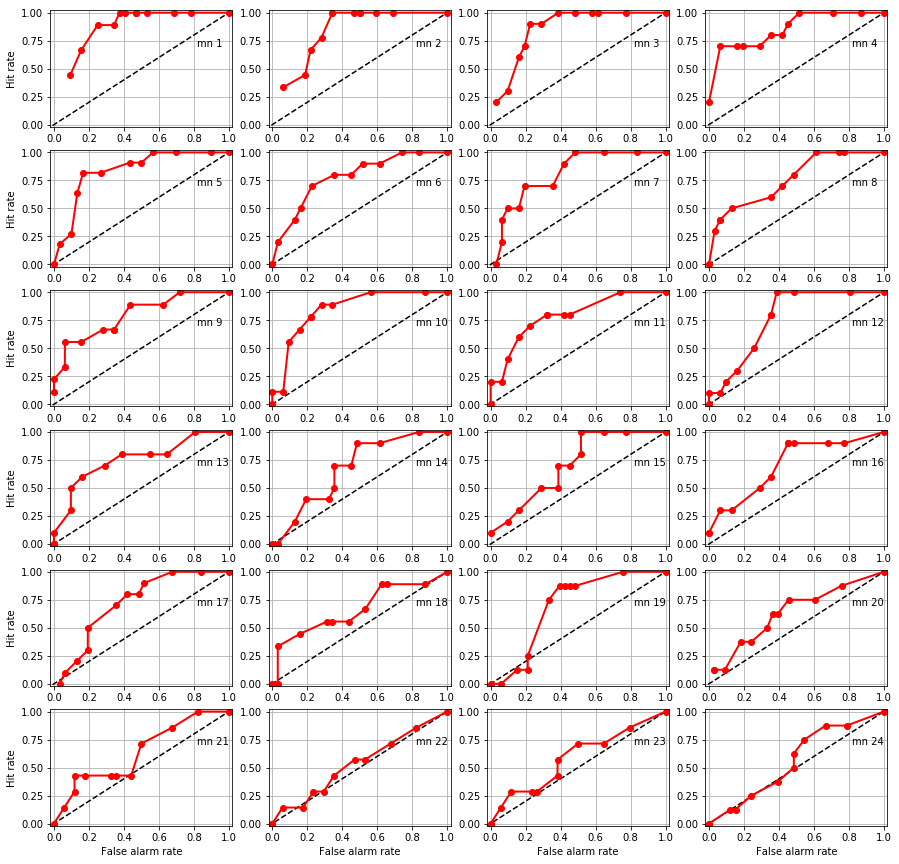

In [27]:
ncol = 4; nrow = int(ceil(len(lead_times)/ncol));
fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

for idx,ax in enumerate(axs.reshape(-1)): 
    ax.grid()
    ax.plot([-1, 2],[-1, 2],'k--')
    ax.plot(roc['false_alarm_rate'].isel(lead_time=idx, drop=True),
            roc['hit_rate'].isel(lead_time=idx, drop=True),'ro-',linewidth=2)
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    ax.text(0.82,0.7,'mn '+str(idx+1))
    
    if idx % ncol == 0:
        ax.set_ylabel('Hit rate')
        
    if idx / ncol >= nrow - 1:
        ax.set_xlabel('False alarm rate')

#### Compute ROC diagram for all lead times

In [28]:
# Compute the event data for forecast likelihood and observations -----
fcst_likelihood = cafeverif.compute_likelihood(cafeverif.did_event(da_fcst, event))
obsv_logical = cafeverif.did_event(da_obsv, event)

# Compute the roc -----
fcst_probabilities = linspace(0,1,len(da_fcst['ensemble'])+1)
roc = cafeverif.compute_roc(fcst_likelihood, obsv_logical, fcst_probabilities, indep_dims=('init_date','lead_time'))

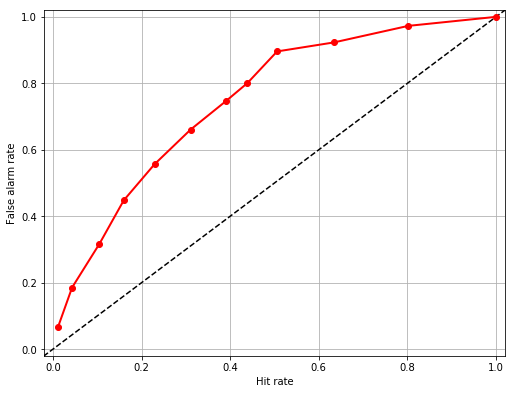

In [29]:
fig1 = plt.figure(figsize=(8,6))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot([-1, 2],[-1, 2],'k--')
ax.plot(roc['false_alarm_rate'],roc['hit_rate'],'ro-',linewidth=2)
ax.set_xlim(-0.02,1.02)
ax.set_ylim(-0.02,1.02)
ax.set_xlabel('Hit rate')
ax.set_ylabel('False alarm rate');

## Discrimination diagram

#### E.g. for the event of monthly rainfall over Tasmania being greater than 100 mm/month

In [30]:
variable = 'precip'

event = '> 100' # for example

# Region of interest -----
# region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

# da_fcst = calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region).compute() 

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
# da_obsv = calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region).compute()

#### Compute discrimination diagrams as a function of lead time

In [31]:
# Compute the event data for forecast likelihood and observations -----
fcst_likelihood = cafeverif.compute_likelihood(cafeverif.did_event(da_fcst, event))
obsv_logical = cafeverif.did_event(da_obsv, event)

# Compute the discrimination -----
fcst_probabilities = linspace(0,1,len(da_fcst['ensemble'])+1)
discrimination = cafeverif.compute_discrimination(fcst_likelihood, obsv_logical, 
                                                  fcst_probabilities, indep_dims='init_date')

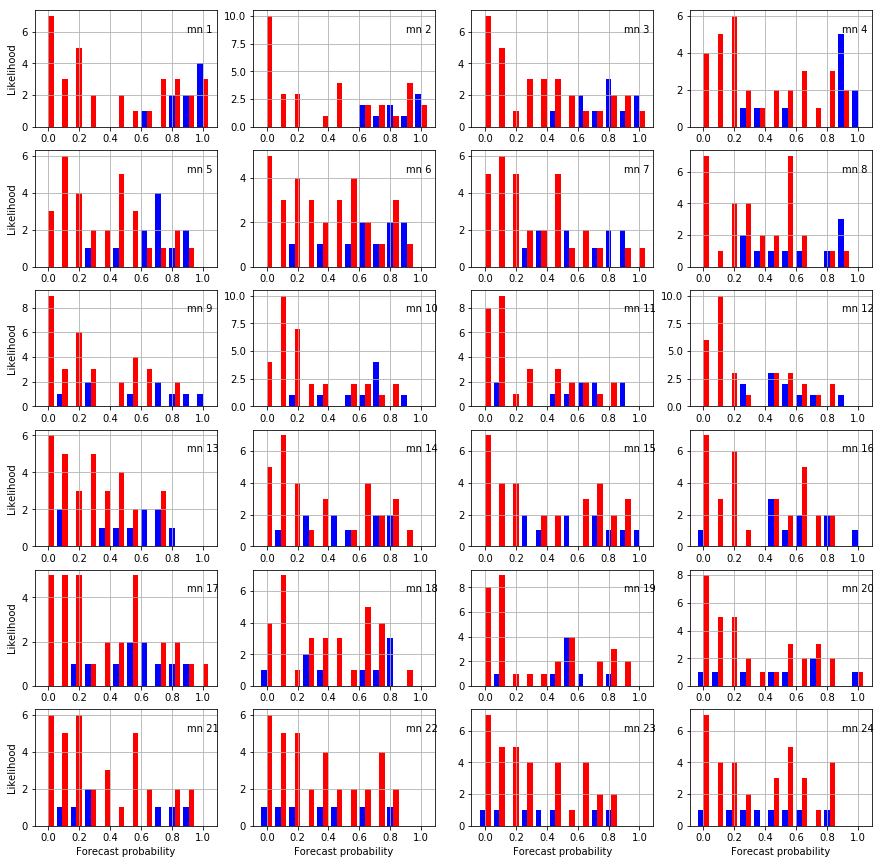

In [32]:
ncol = 4; nrow = int(ceil(len(lead_times)/ncol));
fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

for idx,ax in enumerate(axs.reshape(-1)): 
    ax.grid()
    scale_width = 2.5
    ax.bar(discrimination.bins-discrimination.bins[1]/scale_width/2,
        discrimination['hist_obsved'].isel(lead_time=idx, drop=True),
        width=discrimination.bins[1]/scale_width,
        color='b')
    ax.bar(discrimination.bins+discrimination.bins[1]/scale_width/2,
            discrimination['hist_not_obsved'].isel(lead_time=idx, drop=True),
            width=discrimination.bins[1]/scale_width,
            color='r')
    max_count = max([discrimination['hist_obsved'].isel(lead_time=idx, drop=True).max(), 
                     discrimination['hist_not_obsved'].isel(lead_time=idx, drop=True).max()])
    ax.text(0.9,0.85*max_count,'mn '+str(idx+1))
    
    if idx % ncol == 0:
        ax.set_ylabel('Likelihood')
        
    if idx / ncol >= nrow - 1:
        ax.set_xlabel('Forecast probability')

#### Compute discrimination diagram for all lead times

In [33]:
discrimination = cafeverif.compute_discrimination(fcst_likelihood, obsv_logical, 
                                                  fcst_probabilities, indep_dims=('init_date','lead_time'))

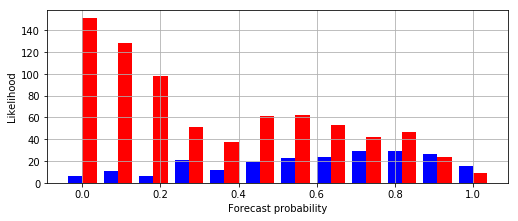

In [34]:
fig1 = plt.figure(figsize=(8,3))

ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.grid()
scale_width = 2.5
ax1.bar(discrimination.bins-discrimination.bins[1]/scale_width/2,
        discrimination['hist_obsved'],
        width=discrimination.bins[1]/scale_width,
        color='b')
ax1.bar(discrimination.bins+discrimination.bins[1]/scale_width/2,
        discrimination['hist_not_obsved'],
        width=discrimination.bins[1]/scale_width,
        color='r')
ax1.set_xlabel('Forecast probability')
ax1.set_ylabel('Likelihood');

# Methods for categorized forecasts

## Contingency table

#### E.g. for 4 categories between 25 and 150 mm of monthly rainfall

In [35]:
# Define category edges -----
category_edges = linspace(25,150,5)

#### Compute contingency as a function of lead time

In [36]:
# Compute contingency table -----
contingency = cafeverif.compute_contingency_table(da_fcst,da_obsv, category_edges,
                                                  ensemble_dim='ensemble', indep_dims=('init_date'))

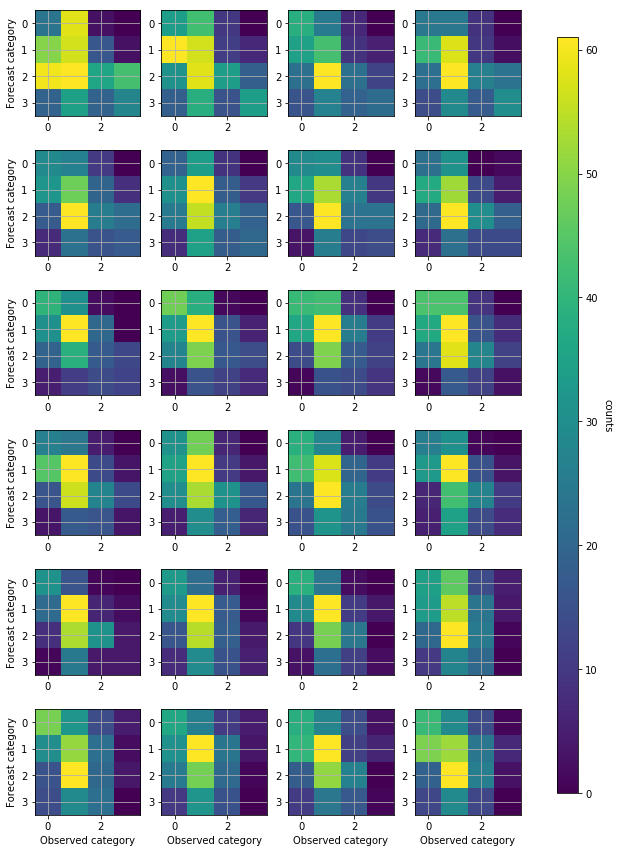

In [37]:
ncol = 4; nrow = int(ceil(len(lead_times)/ncol));
fig, axs = plt.subplots(figsize=(10,15), nrows=nrow, ncols=ncol);

for idx,ax in enumerate(axs.reshape(-1)): 
    ax.grid()
    im = ax.imshow(contingency.isel(lead_time=idx, drop=True))
    # ax.text(0.82,0.7,'mn '+str(idx+1))
    
    if idx % ncol == 0:
        ax.set_ylabel('Forecast category')
        
    if idx / ncol >= nrow - 1:
        ax.set_xlabel('Observed category')
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax);
cbar_ax.set_ylabel('counts', rotation=270, labelpad=15);

#### Compute contingency for all lead times

In [38]:
# Compute contingency table -----
contingency = cafeverif.compute_contingency_table(da_fcst,da_obsv,category_edges,
                                                  ensemble_dim='ensemble',indep_dims=('init_date','lead_time'))

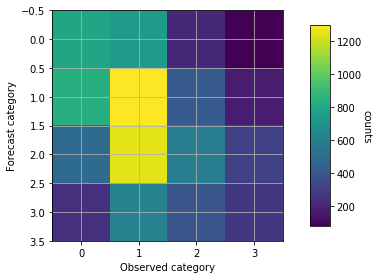

In [39]:
fig = plt.figure(figsize=(9,4))

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
im = ax.imshow(contingency)
ax.set_xlabel('Observed category')
ax.set_ylabel('Forecast category')

cbar_ax = fig.add_axes([0.72, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax);
cbar_ax.set_ylabel('counts', rotation=270, labelpad=10);

## Accuracy score

#### Compute contingency as a function of lead time

In [40]:
# Compute contingency table -----
contingency = cafeverif.compute_contingency_table(da_fcst,da_obsv, category_edges,
                                                  ensemble_dim='ensemble', indep_dims=('init_date'))

In [41]:
accuracy_score = cafeverif.compute_accuracy_score(contingency)

## Heidke skill score

In [42]:
Heidke_score = cafeverif.compute_Heidke_score(contingency)

## Peirce skill score / Hanssen and Kuipers discriminant

In [43]:
Peirce_score = cafeverif.compute_Peirce_score(contingency)

## Gerrity score

In [44]:
Gerrity_score = cafeverif.compute_Gerrity_score(contingency)

#### Plot as a function of lead_time

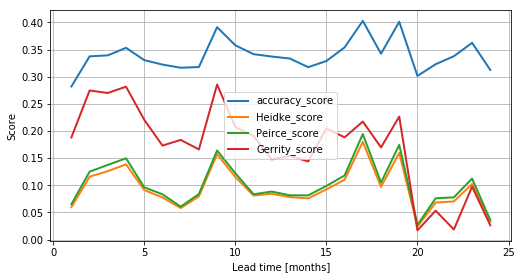

In [45]:
fig1 = plt.figure(figsize=(8,4))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(accuracy_score['lead_time'],accuracy_score,linewidth=2)
ax.plot(Heidke_score['lead_time'],Heidke_score,linewidth=2)
ax.plot(Peirce_score['lead_time'],Peirce_score,linewidth=2)
ax.plot(Gerrity_score['lead_time'],Gerrity_score,linewidth=2)
ax.set_xlabel('Lead time [months]')
ax.set_ylabel('Score');
legend();

# Methods for dichotomously categorized forecasts

## Contingency table

#### E.g. for monthly rainfall being > or < 100 mm 

In [46]:
# Define category edges -----
category_edges = [-inf, 100, inf]

# Compute contingency table -----
contingency = cafeverif.compute_contingency_table(da_fcst,da_obsv,category_edges,
                                                  ensemble_dim='ensemble',indep_dims=('init_date'))

## Bias score

In [47]:
bias_score = cafeverif.compute_bias_score(contingency)

## Probability of detection

In [48]:
hit_rate = cafeverif.compute_hit_rate(contingency)

## False alarm ratio

In [49]:
false_alarm_ratio = cafeverif.compute_false_alarm_ratio(contingency)

## False alarm rate

In [50]:
false_alarm_rate = cafeverif.compute_false_alarm_rate(contingency)

## Success ratio

In [51]:
success_ratio = cafeverif.compute_success_ratio(contingency)

## Threat score

In [52]:
threat_score = cafeverif.compute_threat_score(contingency)

## Equitable threat score

In [53]:
equit_threat_score = cafeverif.compute_equit_threat_score(contingency)

## Odds ratio

In [54]:
odds_ratio = cafeverif.compute_odds_ratio(contingency)

## Odds ratio skill score

In [55]:
odds_ratio_skill = cafeverif.compute_odds_ratio_skill(contingency)

#### Plot as a function of lead time

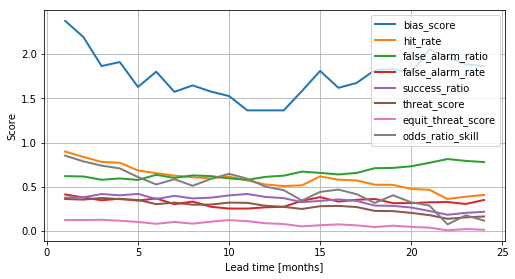

In [56]:
fig1 = plt.figure(figsize=(8,4))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(bias_score['lead_time'],bias_score,linewidth=2)
ax.plot(hit_rate['lead_time'],hit_rate,linewidth=2)
ax.plot(false_alarm_ratio['lead_time'],false_alarm_ratio,linewidth=2)
ax.plot(false_alarm_rate['lead_time'],false_alarm_rate,linewidth=2)
ax.plot(success_ratio['lead_time'],success_ratio,linewidth=2)
ax.plot(threat_score['lead_time'],threat_score,linewidth=2)
ax.plot(equit_threat_score['lead_time'],equit_threat_score,linewidth=2)
# ax.plot(odds_ratio['lead_time'],odds_ratio,linewidth=2)
ax.plot(odds_ratio_skill['lead_time'],odds_ratio_skill,linewidth=2)
ax.set_xlabel('Lead time [months]')
ax.set_ylabel('Score');
legend();

# Methods for continuous variables

## Additive bias error

In [57]:
mean_additive_bias = cafeverif.compute_mean_additive_bias(da_fcst, da_obsv, 
                                                          indep_dims='init_date', ensemble_dim='ensemble')

## Multiplicative bias error

In [58]:
mean_multiplicative_bias = cafeverif.compute_mean_multiplicative_bias(da_fcst, da_obsv, 
                                                                      indep_dims='init_date', ensemble_dim='ensemble')

## Mean absolute error

In [59]:
mean_absolute_error = cafeverif.compute_mean_absolute_error(da_fcst, da_obsv, 
                                                            indep_dims='init_date', ensemble_dim='ensemble')

## Mean squared error

In [60]:
mean_squared_error = cafeverif.compute_mean_squared_error(da_fcst, da_obsv, 
                                                          indep_dims='init_date', ensemble_dim='ensemble')

## Root mean squared error

In [61]:
rms_error = cafeverif.compute_rms_error(da_fcst, da_obsv, 
                                        indep_dims='init_date', ensemble_dim='ensemble')

#### Plot as a function of lead time

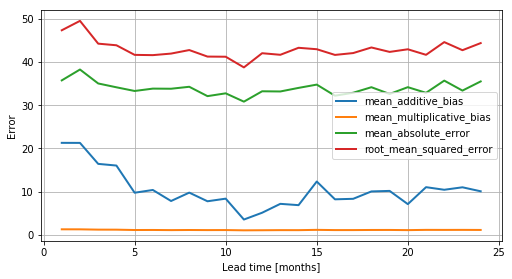

In [62]:
fig1 = plt.figure(figsize=(8,4))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(mean_additive_bias['lead_time'],mean_additive_bias,linewidth=2)
ax.plot(mean_multiplicative_bias['lead_time'],mean_multiplicative_bias,linewidth=2)
ax.plot(mean_absolute_error['lead_time'],mean_absolute_error,linewidth=2)
# ax.plot(mean_squared_error['lead_time'],mean_squared_error,linewidth=2)
ax.plot(rms_error['lead_time'],rms_error,linewidth=2)
ax.set_xlabel('Lead time [months]')
ax.set_ylabel('Error');
legend();

# Close dask client

In [63]:
#client.close()